In [5]:
%matplotlib inline

# add utils
import sys
sys.path.insert(0, '/homes/gt108/Dropbox/python/')
from gtools import *
from gtools.menpo import ImageMatrix
from IPython.display import clear_output

In [6]:
import theano

In [7]:
from __future__ import print_function
from pathlib  import Path
from xml.dom import minidom
from menpo.io import import_images
import numpy as np

root = '/vol/hci2/Databases/video/MMI/Sessions/'

dictionary = {}

with open('/vol/atlas/homes/gt108/db/smile_auc_12.list') as f:
    
    for line in f.readlines():
        name =  line.split('/')[2].split('oao')[0][:-1]
        
        xml = minidom.parse(open(root + line.strip() ))

        markers = [it.getElementsByTagName('Marker') for it in xml.getElementsByTagName('ActionUnitCoding')[0].getElementsByTagName('ActionUnit') if it.getAttribute('Number') == '12'][0]
        dictionary[name] = [ (int(m.getAttribute('Frame')), int(float(m.getAttribute('Type')))) for m in markers ]

In [8]:
def fill_frames(assets):
    images = []

    for a, b in zip(assets, assets[1:]):

        i, j = [int(x.path.stem.split('_')[1]) for x in [a, b]]

        j = int(b.path.stem.split('_')[1])

        for _ in range(i, j):
            images.append(a)
    return images

In [9]:
gnd = []
Xs  = []

for path in show_status(Path('/vol/atlas/homes/gt108/db/MMI_smile/').glob('*frames')):
    name = path.stem.split('_')[0]
    print("\nLoading [%s]" % name)
    
    try:
        assets = list(import_images(path, verbose=True))
        assets = sorted(assets, key=lambda a: int(a.path.stem.split('_')[1]))
        assets = fill_frames(assets)

    except Exception as e:
        print(e)
        continue
    
    gnd.append(dictionary[name])
    Xs.append(assets)
    clear_output(wait=True)


Loading [S048-005]
The glob /vol/atlas/homes/gt108/db/MMI_smile/S048-005_frames yields no assets

Loading [S006-026]
- Loading 73 assets: [====================] 100%

In [10]:
for subject_assets in Xs:
    for img in subject_assets:
        img.crop_to_landmarks_inplace()

In [11]:
Xs_pixels = [ np.array([x.resize((30, 30)).as_greyscale().pixels.ravel()  for x in X], 'float32') for X in show_status(Xs) ]

In [12]:
from time_warping import aliGN

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [13]:
def distance_nicolaou(P, i, j):
    res = [{}, {}]
    
    for num, k in enumerate([i, j]):
        g = np.array(gnd[k])

        frames =  sorted(g[:, 0]) + [len(Xs[k])-1]
        
        for (start, t), end in zip(zip(frames, g[:, 1]), frames[1:]):
            start = np.where(np.array(P)[:, num] == start)[0][0]
            end = np.where(np.array(P)[:, num] == end)[0][-1] 
            if t not in res[num]:
                res[num][t] = set()
                
            res[num][t].update(set(range(start, end+1)))
            
    results = []
    
    for i in range(4):
        if i not in res[0] or i not in res[1]:
            results.append(1)
            continue
            
        s1 = res[0][i]
        s2 = res[1][i]
        
        inter = len(s1.intersection(s2))
        union = len(s1.union(s2))
        results.append(inter/float(union))
        
    
    return [np.mean(results)] + results
                
def distance_rms(P, i, j):
    P = P - 1
    res = [[], []]
    
    for state in range(0, 4):
        for num, k in enumerate([i, j]):
            g = np.array(gnd[k])
            for f in g[g[:, 1] == state, 0]:
                al = np.where(np.array(P)[:, num] == f)[0]
                res[num].append(al[len(al)/2])
    
    res = np.array(res, float)

    return np.sqrt(((res[0] - res[1])**2).sum()/5.)

# print(distance(aliF, 0, 9))
# print(distance(aliF_ctw, 0, 9))
# print(distance(aliF_dtw, 0, 9))

In [14]:
from sklearn.decomposition import PCA
pca = PCA(150)
pixels = np.vstack(Xs_pixels)
pca.fit(pixels)

PCA(copy=True, n_components=150, whiten=False)

In [15]:
Xs_u_whitened = [pca.transform(x) for x in Xs_pixels]

In [16]:
# errors = []
# subs = [0, 1, 5, 6, 12, 16, 18, 19, 24, 25]
# for i in range(10):
#     for j in range(i+1, 10):
#         error = 100
#         for _ in range(5):
#             try:
#                 dcca = DeepCCA([Xs_aligned[subs[i]], Xs_aligned[subs[j]]], dim=10, max_iter=400)
#                 Ys = dcca.project([Xs_u_whitened[subs[i]], Xs_u_whitened[subs[j]]])
#                 aliF, _, _ = aliGN([y.T for y in Ys], verbose=False, dtw=True)
#                 error = distance_nicolaou(aliF, subs[i], subs[j])
#             except ValueError as e:
#                 continue
        
#             break
            
#         print("[{}-{}] {}".format(subs[i], subs[j], error))
#         if error != 100:
#             errors.append(error)

In [21]:
import ddtw 
reload(ddtw)

subj = [0, 18]
Vs = [Xs_u_whitened[subj[0]], Xs_u_whitened[subj[1]]]

P = np.zeros((max([x.shape[0] for x in Vs]), len(Vs)), int)
for i in range(P.shape[1]):
    P[:, i] = np.linspace(0, Vs[i].shape[0] -1, num=P.shape[0]).round()
        
def metric(align):
    return distance_nicolaou(align, subj[0], subj[1])[0]
        
        
dcca = ddtw.DeepCTW(Vs, P, metric, dim=10, max_iter=100, X_valid=None)
Ys = dcca.project()

aliF, _, _ = aliGN([y.T for y in Ys], verbose=False, dtw=True)
# print(distance(aliF, subj[0], subj[1]))
print(distance_nicolaou(aliF, subj[0], subj[1])[0])

KeyboardInterrupt: 

In [635]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_align(P, subj):
    sns.set_style('whitegrid')
    ax = plt.figure(figsize=(6, 5)).add_subplot(111)
    ax.plot(P)

    plt.xlim(0, P.shape[0])
    plt.ylim(0, P.shape[0])

    fs = []

    names = "neutral,onset,apex,offset".split(',')

    for num, k in enumerate(subj):

        for j in range(0, 4):
            g = np.array(gnd[k])
            for f in g[g[:, 1] == j, 0]:
                al = np.where(np.array(P)[:, num] == f)[0]
                p = al[len(al)/2]

                ax.scatter(p, f)
                ax.annotate(names[j], (p-10+num*20, f+3))

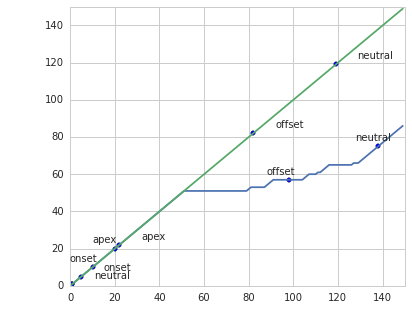

In [643]:
plot_align(aliF, subj)

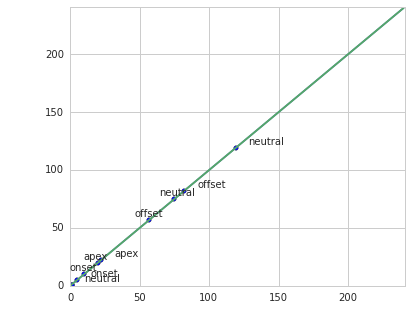

In [638]:
from time_warping import aliGN

aliF_ctw, _, _ = aliGN([Xs_aligned[subj[0]].T, Xs_aligned[subj[1]].T], verbose=False, dtw=True)
plot_align(aliF_dtw, subj)

In [642]:
aliF.dtype

dtype('int64')

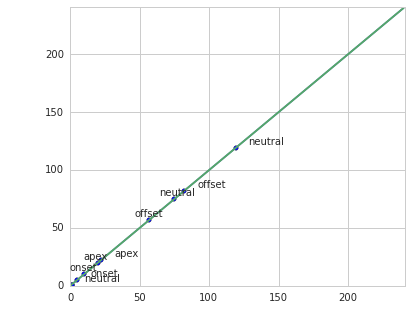

In [639]:
aliF_ctw, _, _ = aliGN([Xs_aligned[subj[0]].T, Xs_aligned[subj[1]].T], verbose=False, dtw=True)
plot_align(aliF_ctw, subj)

In [580]:
print(np.where(aliF_dtw[:, 0] == 5)[0][0])
print(np.where(aliF_dtw[:, 1] == 24)[0][0])

5
24


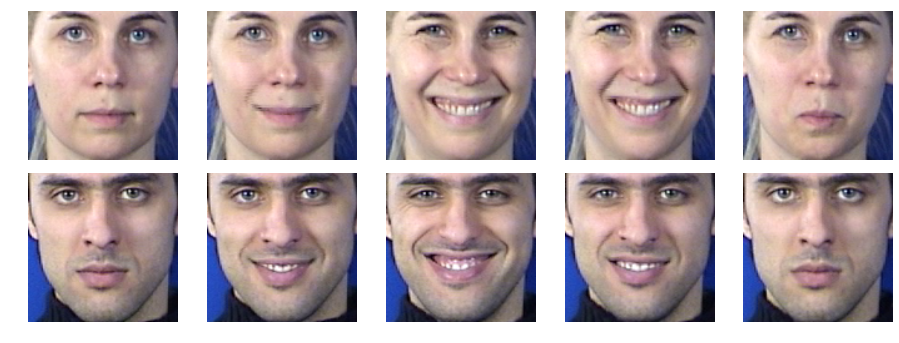

In [613]:
plot_video(subj, aliF)

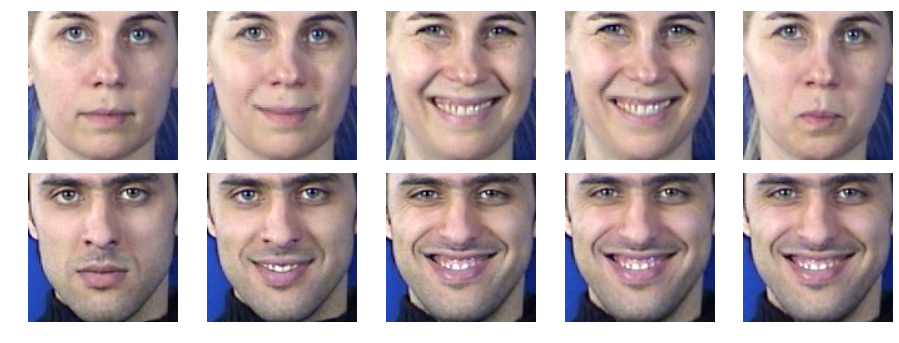

In [615]:
plot_video(subj, aliF_dtw)

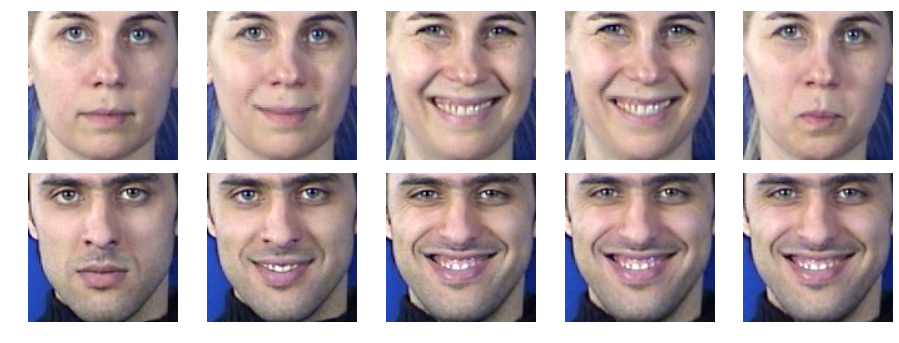

In [616]:
plot_video(subj, aliF_ctw)

In [601]:
def plot_video(subj, P, num_samples=10):
    indices = [np.where(P[:, 0] == i)[0][0] for i in np.array(gnd[subj[0]])[:, 0]]
    plt.figure(figsize=(30, 50))

    for num, i in enumerate(indices, start=1):
        plt.subplot(2, len(indices), num)

        img = Xs[subj[0]][P[i, 0]].resize((120, 120)).pixels.transpose(1, 2, 0)

        plt.imshow(img)
        plt.axis('off')

        plt.subplot(2, len(indices), num+len(indices))
        img = Xs[subj[1]][P[i, 1]].resize((120, 120)).pixels.transpose(1, 2, 0)

        plt.imshow(img)

        plt.axis('off')

    plt.subplots_adjust(hspace = 0, top = 0.09, bottom = 0, left=0, right=.4)